In [54]:
import numpy as np
import pandas as pd 
import random as rn

# tensorflow
import tensorflow as tf
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Chart
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import glob

from skimage import color, exposure
from sklearn.metrics import classification_report

import os
import cv2

# Setting the same seed for repeatability

seed = 0

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


In [64]:
data_path = "D:\AI Folder\chest_xray"



train_path = data_path + '\\train\\'
test_path = data_path + '\\test\\'
#val_path = data_path + '\\val\\'
img_size = 200

In [65]:
def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
            
    images = np.asarray(images)
    return images


In [66]:
train = read_data([train_path])
test = read_data([ test_path])

C:\Users\vasuk\AppData\Local\Temp\ipykernel_20760\1786607454.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.asarray(images)


In [67]:
for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [68]:
train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

C:\Users\vasuk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\vasuk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


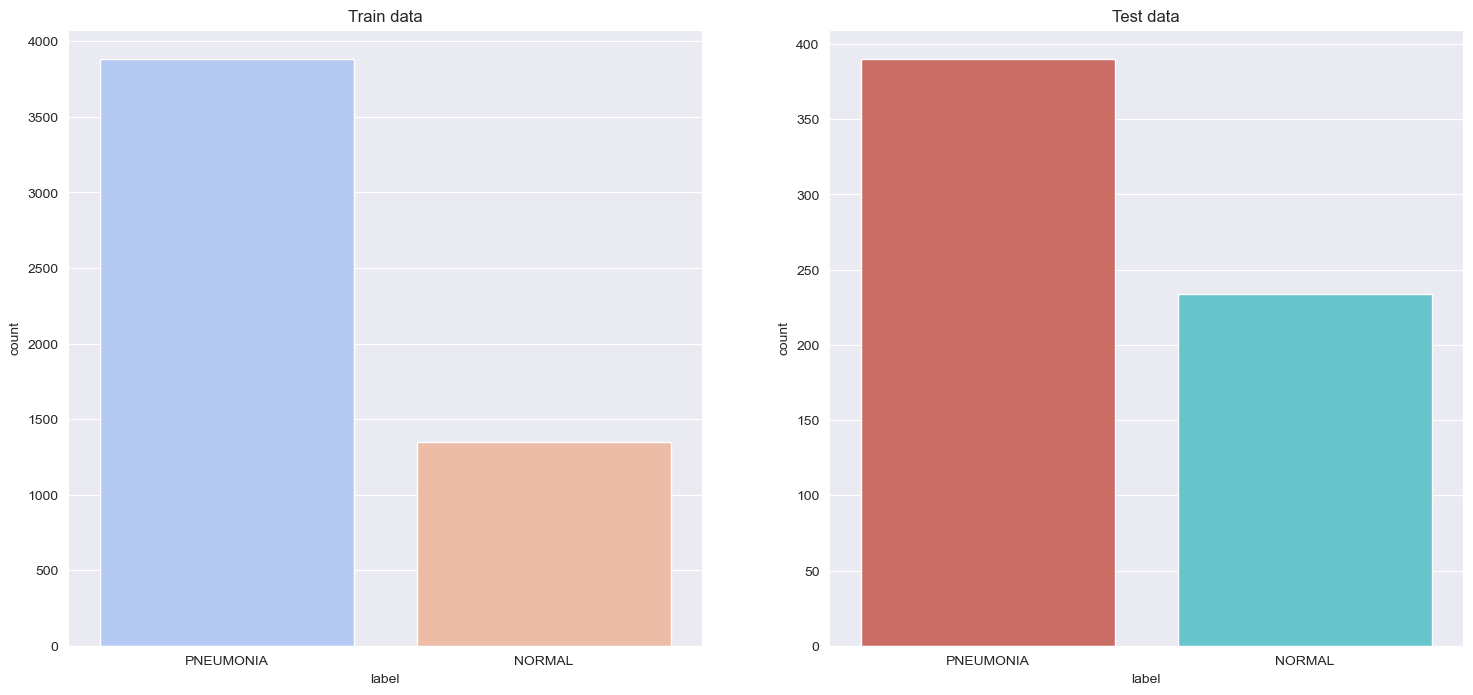

In [69]:
plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "hls")
plt.title('Test data')

plt.show()

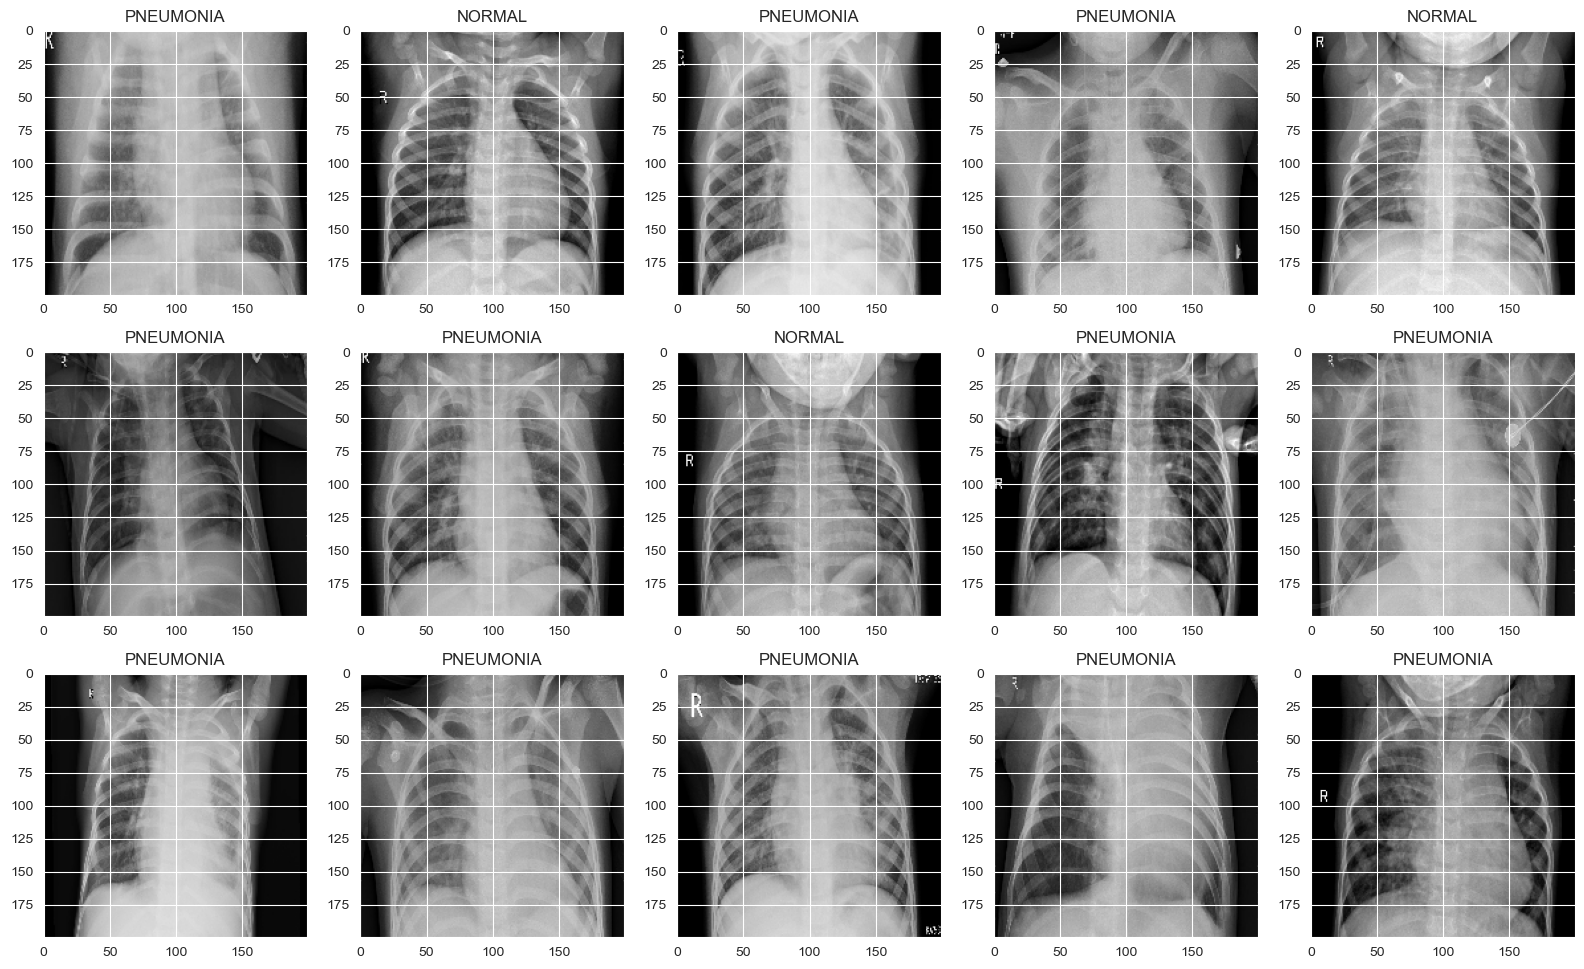

In [70]:
def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_example_image()

In [71]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

In [72]:
def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [73]:
np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [74]:
def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

In [75]:
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [76]:
def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 255
    return data1

In [77]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [78]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.25, random_state=42)

In [79]:
num_classes = y_train.shape[1]

In [80]:
input_shape = (img_size, img_size, 1)

In [81]:
datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 32)

In [82]:
callbacks4 = [ 
    EarlyStopping(monitor = 'loss', patience = 7), 
    ReduceLROnPlateau(monitor = 'loss', patience = 4), 
    ModelCheckpoint('../working/model.best4.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [83]:
def get_modelcnn_v2():
    return Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Flatten(),
       
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(num_classes, activation = "softmax")
        
    ])

In [84]:
custom_model = get_modelcnn_v2()
custom_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      4

In [85]:
learning_history = custom_model.fit_generator((train_gen), 
                               epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_val, y_val),
                               callbacks = callbacks4,
                        )

Epoch 1/100


C:\Users\vasuk\AppData\Local\Temp\ipykernel_20760\954539191.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  learning_history = custom_model.fit_generator((train_gen),


122/122 [==============================] - 215s 2s/step - loss: 0.5933 - accuracy: 0.7323 - val_loss: 0.9675 - val_accuracy: 0.2592 - lr: 0.0010
Epoch 2/100
122/122 [==============================] - 204s 2s/step - loss: 0.3324 - accuracy: 0.8679 - val_loss: 3.3965 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 3/100
122/122 [==============================] - 203s 2s/step - loss: 0.2534 - accuracy: 0.9078 - val_loss: 3.1886 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 4/100
122/122 [==============================] - 199s 2s/step - loss: 0.2168 - accuracy: 0.9198 - val_loss: 1.6641 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 5/100
122/122 [==============================] - 196s 2s/step - loss: 0.2214 - accuracy: 0.9144 - val_loss: 1.5998 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 6/100
122/122 [==============================] - 201s 2s/step - loss: 0.1820 - accuracy: 0.9296 - val_loss: 0.8971 - val_accuracy: 0.7416 - lr: 0.0010
Epoch 7/100
122/122 [==============================] - 203s 2s/step - 

In [86]:
custom_model.save('scratch.h5')

In [87]:
model = tf.keras.models.load_model('scratch.h5')

In [88]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 49.60542321205139%
Test accuracy: 86.69871687889099%
MLP Error: 13.30%


In [89]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

20/20 [==============================] - 5s 234ms/step


In [90]:
y_pre_test = np.argmax(y_test, axis = 1)

In [91]:
def show_condition(num):
    if num == 0:
        return 'NORMAL'
    return 'PNEUMONIA'

C:\Users\vasuk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


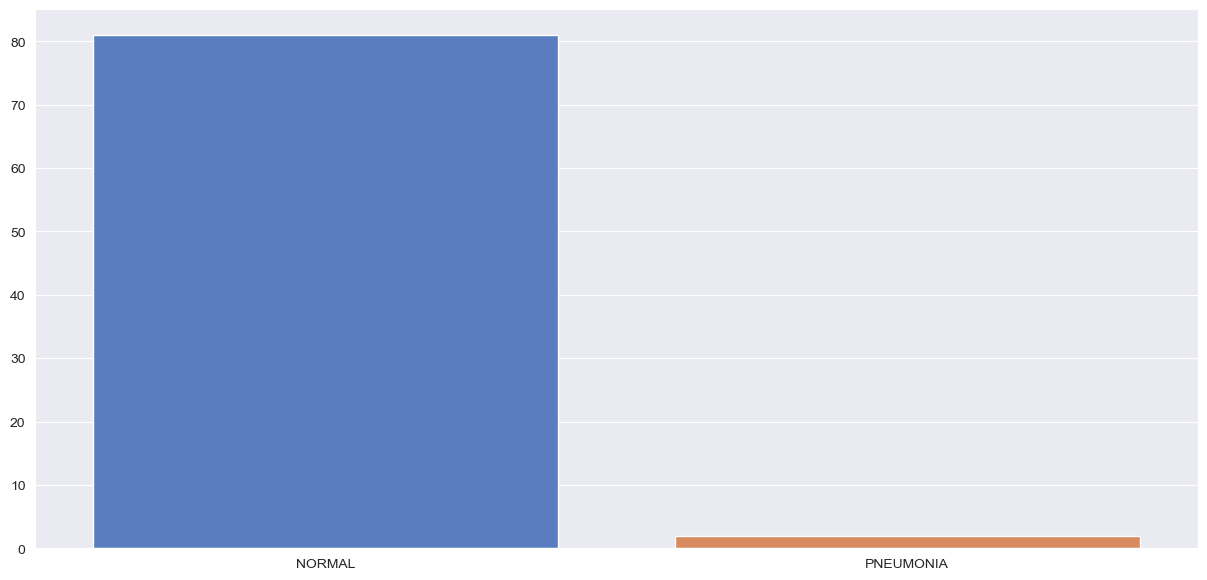

In [92]:
cnt_error = []
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if a == b: continue
    cnt_error.append(a)# test

cnt_error = np.unique(cnt_error, return_counts = True)
sns.set_style("darkgrid")
plt.figure(figsize = (15, 7))
sns.barplot([show_condition(x) for x in cnt_error[0]], cnt_error[1], palette="muted")
plt.show()

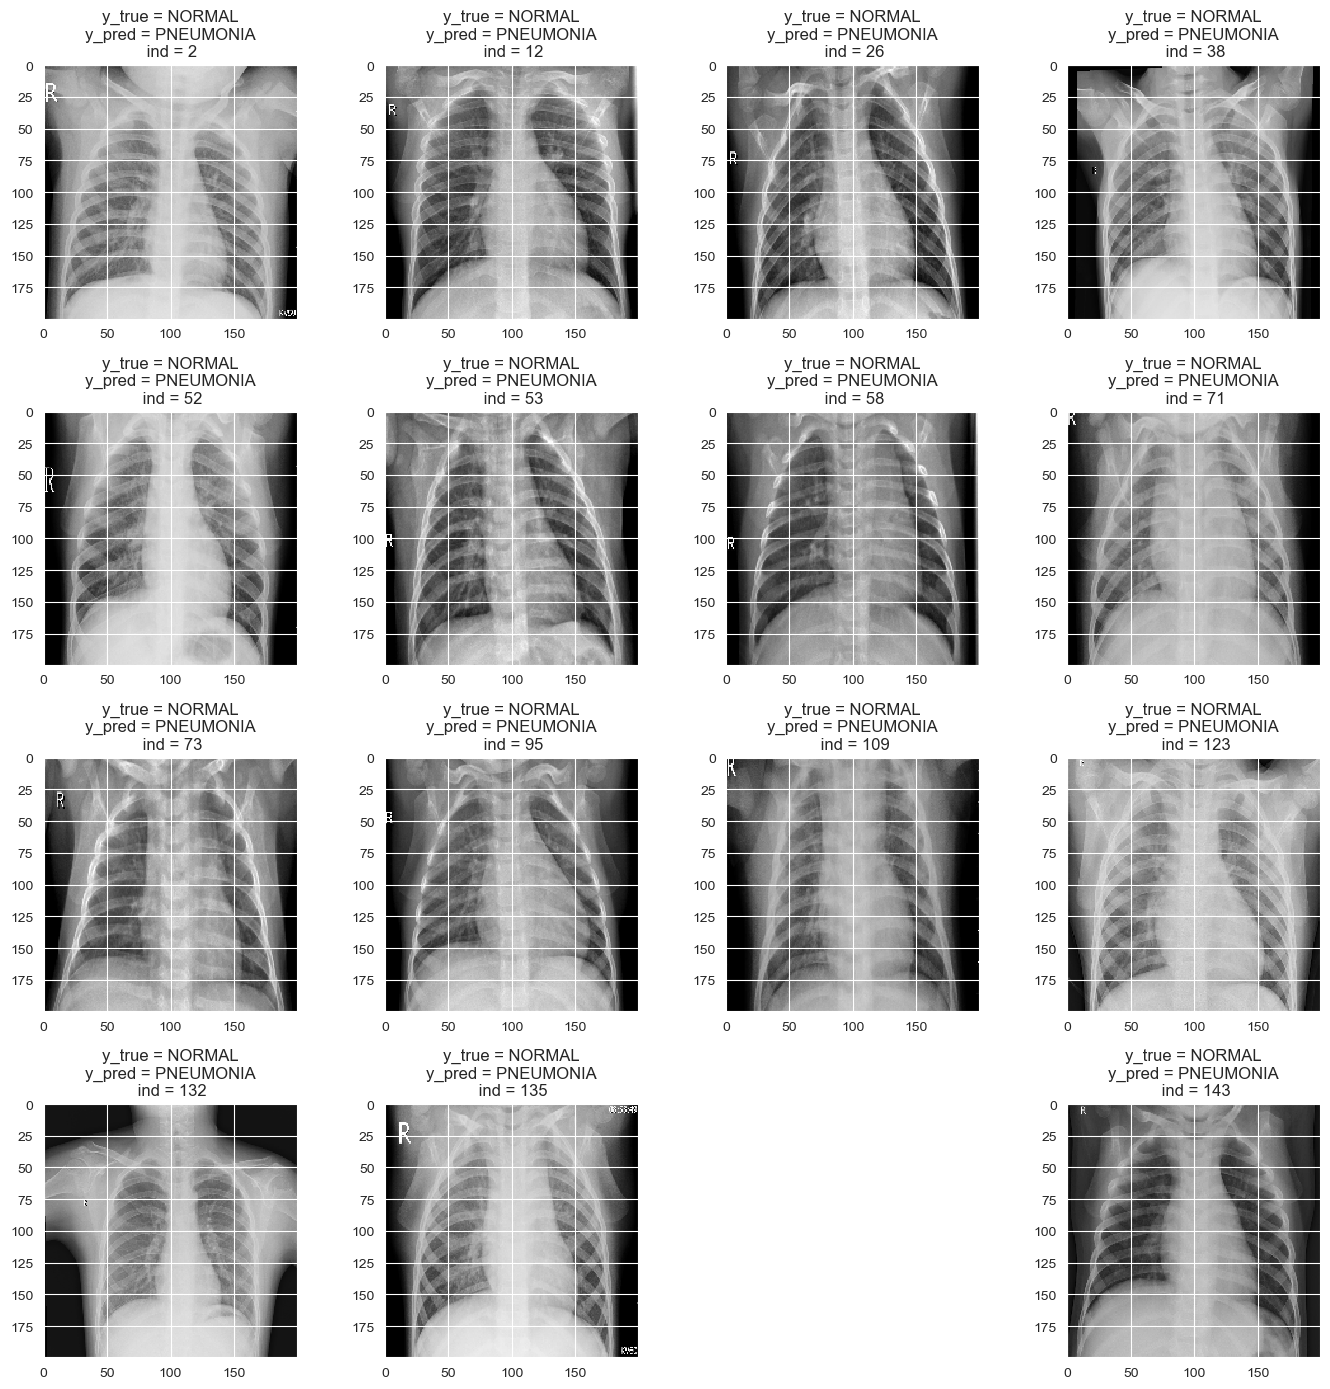

In [93]:
cnt_ind = 1
list_idx = []
fig = plt.figure(figsize=(14, 14))
X_test_plot = X_test.reshape(-1, img_size, img_size)
for idx, (a, b) in enumerate(zip(y_pre_test, y_pred)):
    if(cnt_ind > 16):break
    if a == b: continue
    plt.subplot(4, 4, cnt_ind)
    plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
    plt.title('y_true = {0}\ny_pred = {1}\n ind = {2}'.format(show_condition(a), show_condition(b), idx))
    plt.tight_layout()
    list_idx.append(idx)
    cnt_ind += 1

In [94]:
print(classification_report(y_pre_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.65      0.79       234
           1       0.83      0.99      0.90       390

    accuracy                           0.87       624
   macro avg       0.91      0.82      0.85       624
weighted avg       0.89      0.87      0.86       624



In [95]:
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,accuracy_score
precision = precision_score(y_pre_test, y_pred)
recall = recall_score(y_pre_test, y_pred)
f1score = f1_score(y_pre_test, y_pred)
acc = accuracy_score(y_pre_test,y_pred)
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")
print(f"Accuracy = {acc}")

Precision = 0.8272921108742004
Recall = 0.9948717948717949
F1 Score = 0.9033760186263097
Accuracy = 0.8669871794871795


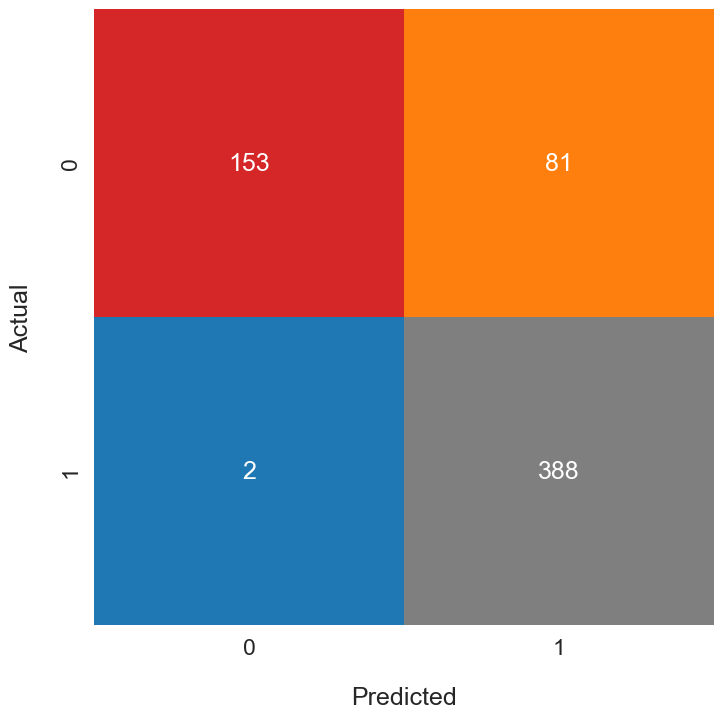

In [96]:
conf_matrix = confusion_matrix(y_pre_test, y_pred)

plt.figure(figsize=(8,8))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    conf_matrix, annot=True, fmt='d', 
    cbar=False, cmap='tab10', vmax=500 
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()